# Drift correction

...for GPS tracks collected on drifting sea ice.

### needed:
- a mobile GPS track with X and Y (long, lat) coordinate pairs which needs drift removed
- a reference GPS track which contains the drift to be removed (eg from a fixed-to-floe GPS)

### basic strategy:
1. collect a common time window between the reference and mobile GPS track
2. choose a projected coordinate system expressed in meters, and reproject both GPS tracks to it
3. if one track has a higher time resolution, interpolate the other track so that both tracks have the same time resolution
4. subtract the reference track positions from the mobile track positions

### caveat:

This strategy assumes the ice floe has not rotated significantly during the survey.

In [10]:
## import all the libraries

# standard stuff
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime, timedelta

# reprojection help
import pyproj
from pyproj import CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info

# xml help for GPX files
import xml.etree.ElementTree as et

# cartopy, basemap is deprecated

In [11]:
## functions we make ourselves go here

## these are from PhD work in 2015
def trim_timeseries(t1, t2):
#trim a long timeseries to match a shorter one.
#t1 is the long series, t2 is the short sries
#returns a set of indices to apply to the longer
#timeseries dataset
    start = np.min(t2)-1
    end = np.max(t2)+1
    idx = (t1>=start)*(t1<=end)
    the_inds = np.where(idx)
    return np.asarray(the_inds), start, end

## this was used for lidar work, but not here - instead we get an exact time match to an image trajectory
def find_nearest_vector(array, value):
#http://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
  idx = np.array([np.linalg.norm(x+y) for (x,y) in array-value]).argmin()
  return idx

# sometimes we can get lucky and get proj to find a UTM code for us
def getutm(lon,lat):
    utm_crs_list = query_utm_crs_info(
        datum_name="WGS 84",
        area_of_interest=AreaOfInterest(
            west_lon_degree=lon-0.1,
            south_lat_degree=lat-0.1,
            east_lon_degree=lon+0.1,
            north_lat_degree=lat+0.1,
            ),
        )
    print(utm_crs_list)
    return utm_crs_list[0].code

# convert from lat lon to UTM
def makeutm(lon,lat,utmcode):
    
    thetransform = pyproj.transformer.Transformer.from_proj(4326,utmcode)
    gnssutm=thetransform.transform(lat, lon)
    east = gnssutm[0]
    north = gnssutm[1]
    
    return east, north

def readbasegps(filename):
    if 'gpx' in filename:
        # do xml parsing
        tree = et.parse(filename)
        print(filename)
        root = tree.getroot()
        trk = root.find('{http://www.topografix.com/GPX/1/1}trk')
        trksegs = trk.findall('{http://www.topografix.com/GPX/1/1}trkseg')
        trkpts = []
        for trkseg in trksegs:
            trkpts = trkpts + trkseg.findall('{http://www.topografix.com/GPX/1/1}trkpt')
        lon_pts = [float(trkpt.get('lon')) for trkpt in trkpts]
        lat_pts = [float(trkpt.get('lat')) for trkpt in trkpts]
        thetimes = [datetime.strptime(trkpt.find('{http://www.topografix.com/GPX/1/1}time').text,'%Y-%m-%dT%H:%M:%SZ')  for trkpt in trkpts]
        
        start_time = trkpts[0].find('{http://www.topografix.com/GPX/1/1}time')
        #start_time = datetime.strptime(start_time.text, '%Y-%m-%dT%H:%M:%SZ')
        
        stop_idx = max(np.nonzero(np.diff(lat_pts))[0][-1],np.nonzero(np.diff(lon_pts))[0][-1])
        lon_pts = lon_pts[:stop_idx]
        lat_pts = lat_pts[:stop_idx]
        times = thetimes[:stop_idx]
        
    else:
        # assume POS CVS file, read with Pandas
        gnsstrack = pd.read_csv(filename,
                       skiprows=18)
        
        thetimes = gnsstrack[gnsstrack.keys()[0]].values
        print(thetimes[0:4])
        lat_pts = gnsstrack[" latitude(deg)"].values
        lon_pts = gnsstrack["longitude(deg)"].values
        # remove any leading or trailing spaces from the time string using strip,
        # drop precision to milliseconds (6 decimal places) by removing the last 0
        # then convert it to a datetime object
        times = [datetime.strptime(thistime.strip()[0:-1], "%Y/%m/%d %H:%M:%S.%f") for thistime in thetimes]
    
    #return lists of lon, lat and time, we do reprojection in its own function later
    return lon_pts, lat_pts, times

In [12]:
# A function to find matching timestamps

def findtimes(highrestimes, lowrestimes):
    
    # interpolate times to match resolutions
    
    
    
    
    # 
    i=0
    timeindexes = []
    for thistime in gem2dayseconds:
        thistimeindex = np.where(timesteps[:] == thistime)
        if thistimeindex[0].size > 0:
            timeindexes.append(thistimeindex[0])
    
    

In [13]:
gpxfile = "/mnt/documents/Q1/P6-14032021/gnss/Tracker1_St/Day1/Current.gpx"
#gem2inputfile = "/mnt/documents/Q1/P6-14032021/GEM2/Q1-P6-transect-14032021-gem2-531-channel-thickness.csv"


In [14]:
glon, glat, gtimes = readbasegps(gpxfile)

/mnt/documents/Q1/P6-14032021/gnss/Tracker1_St/Day1/Current.gpx


In [15]:
gtimes[0]

datetime.datetime(2021, 3, 14, 15, 47, 32)

In [16]:
gtimes[-1]

datetime.datetime(2021, 3, 14, 16, 53, 38)

Now we have an ice floe drift track loaded, either from a handheld GPS fixed to the ice (gpx files) or kPPP processed GPS base stations (pos files)

### Transform track data to UTM (or other projected system measured in meters)

In [17]:
## get the UTM zone
utmzone=getutm(glon[0], glat[0])
utmzone

[CRSInfo(auth_name='EPSG', code='32636', name='WGS 84 / UTM zone 36N', type=<PJType.PROJECTED_CRS: 'PROJECTED_CRS'>, deprecated=False, area_of_use=AreaOfUse(west=30.0, south=0.0, east=36.0, north=84.0, name='Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.'), projection_method_name='Transverse Mercator')]


'32636'

In [18]:
## set up the proj transformer

thetransform = pyproj.transformer.Transformer.from_proj(4326,3413)

In [19]:
gnssutm = thetransform.transform(glat, glon)
gnssutm = np.array(gnssutm)

## Convert time to seconds-of-day

**check time zones! Use UTC.**

In [20]:
gnssdayseconds=[]
for thetime in gtimes:
    hour = datetime.strftime(thetime, "%H")
    minute = datetime.strftime(thetime, "%M")
    second = datetime.strftime(thetime, "%S")
    millisecond = float(datetime.strftime(thetime, "%f")) / 1000000
    gnssdayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + int(second) + float(millisecond))

In [21]:
gnssdayseconds[0:5]

[56852.0, 56854.0, 56855.0, 56856.0, 56857.0]

## Load  GEM2 data to be drift corrected

In [18]:
gem2inputfile = "/mnt/documents/Q1/P6-14032021/GEM2/Q1-P6-transect-14032021-gem2-531-channel-thickness.csv"

In [19]:
gem2data = pd.read_csv(gem2inputfile)

In [20]:
gem2data

time   record_id   longitude   latitude   xc  \
0      2021-03-14T15:54:03.765625           0         0.0        0.0  0.0   
1      2021-03-14T15:54:03.859375           1         0.0        0.0  0.0   
2      2021-03-14T15:54:03.968750           2         0.0        0.0  0.0   
3      2021-03-14T15:54:04.062500           3         0.0        0.0  0.0   
4      2021-03-14T15:54:04.156250           4         0.0        0.0  0.0   
...                           ...         ...         ...        ...  ...   
17006  2021-03-14T16:32:30.093750       17006         0.0        0.0  0.0   
17007  2021-03-14T16:32:30.203125       17007         0.0        0.0  0.0   
17008  2021-03-14T16:32:30.296875       17008         0.0        0.0  0.0   
17009  2021-03-14T16:32:30.390625       17009         0.0        0.0  0.0   
17010  2021-03-14T16:32:30.500000       17010         0.0        0.0  0.0   

        yc   f450Hz_hcp_i   f450Hz_hcp_q   f1530Hz_hcp_i   f1530Hz_hcp_q  \
0      0.0          0.060          0.436           0.473           0.472   
1      0.0          0.141          0.462           0.499           0.473   
2      0.0          0.379          0.491           0.443           0.467   
3      0.0          0.216          0.520           0.438           0.468   
4      0.0         -0.254          0.492           0.565           0.474   
...    ...            ...            ...             ...             ...   
17006  0.0          0.220          0.359           0.378           0.408   
17007  0.0         -0.196          0.377           0.423           0.413   
17008  0.0          0.099          0.407           0.467           0.407   
17009  0.0          0.867          0.405           0.387           0.404   
17010  0.0          0.797          0.372           0.406           0.405   

        f5310Hz_hcp_i   f5310Hz_hcp_q   f18330Hz_hcp_i   f18330Hz_hcp_q  \
0               0.477           0.462            0.454            0.461   
1               0.473           0.463            0.456            0.462   
2               0.468           0.464            0.454            0.461   
3               0.471           0.463            0.454            0.461   
4               0.471           0.463            0.456            0.460   
...               ...             ...              ...              ...   
17006           0.417           0.394            0.398            0.381   
17007           0.413           0.392            0.399            0.382   
17008           0.417           0.392            0.400            0.382   
17009           0.414           0.395            0.400            0.382   
17010           0.406           0.396            0.400            0.380   

        f63030Hz_hcp_i  f63030Hz_hcp_q  
0                0.444             nan  
1                0.445             nan  
2                0.445             nan  
3                0.445             nan  
4                0.444             nan  
...                ...             ...  
17006            0.388             nan  
17007            0.388             nan  
17008            0.389             nan  
17009            0.389             nan  
17010            0.388             nan  

[17011 rows x 16 columns]

In [21]:
gem2data.drop(gem2data[gem2data[" longitude"] == 0].index, inplace=True)
gem2data.drop(gem2data[gem2data[" latitude"] == 0].index, inplace=True)

In [22]:
f1530hz_hcp_i = [float(zi) for zi in gem2data[" f1530Hz_hcp_i"].values]

In [23]:
gem2utm = thetransform.transform(gem2data[" latitude"].values, gem2data[" longitude"].values)

In [24]:
gem2easting = gem2utm[0]
gem2northing = gem2utm[1]

Text(0.5, 1.0, 'uncorrected drift track - local coordinates')

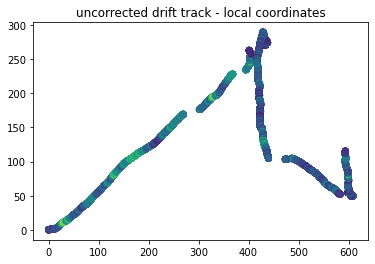

In [25]:
plt.scatter(gem2easting-np.min(gem2easting), gem2northing-min(gem2northing), c = f1530hz_hcp_i)
plt.title("uncorrected drift track - local coordinates")

In [26]:
gem2times = gem2data['time'].values
gem2dayseconds=[]
for thetime in gem2times:
    thisdate, thistime = thetime.split('T')
    #print(thistime)
    hour, minute, second = thistime.split(':')
    #print(len(thetime))
    #print(thetime)
    gem2dayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + float(second))

In [27]:
gem2dayseconds = np.round(gem2dayseconds, 4)

In [64]:
len(gem2dayseconds)

16810

In [33]:
gnssdayseconds

array([56852., 56854., 56855., ..., 60816., 60817., 60818.])

In [36]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, gem2dayseconds)

In [45]:
gnss_trimmedtime = np.squeeze(gnss_trimmedtime)

In [48]:
gnss_trimmedtime[0])

numpy.int64

In [50]:
gnssutm = np.array(gnssutm)

In [51]:
gnssutm[0][gnss_trimmedtime]

array([891355.52084618, 891355.706811  , 891355.99279336, ...,
       891937.40596197, 891937.64329162, 891937.87997618])

In [52]:
gnssdayseconds = np.array(gnssdayseconds)

In [53]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [54]:
trimmedtime.size

2307

In [66]:
timesteps = np.arange(trimmedtime.min()-0.01, trimmedtime.max()+0.01, 0.0001)
timesteps = np.round(timesteps, 4)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)
    

In [67]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in gem2dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])
    else:
        print(thistimeindex[0])

CPU times: user 3min 5s, sys: 11.3 ms, total: 3min 5s
Wall time: 3min 5s


In [68]:
len(timeindexes)

16810

In [69]:
len(gem2easting)

16810

In [70]:
gnss_gem2_match_eastings = interp_east[timeindexes]
gnss_gem2_match_northings = interp_north[timeindexes]

In [71]:
gnss_gem2_match_eastings = np.squeeze(gnss_gem2_match_eastings)
gnss_gem2_match_northings = np.squeeze(gnss_gem2_match_northings)

In [72]:
local_gem2_east = gem2easting - gnss_gem2_match_eastings
local_gem2_north = gem2northing - gnss_gem2_match_northings

In [73]:
local_gem2_east.size

16810

In [153]:
world_gem2_east = local_gem2_east + gnssutm[0][0]
world_gem2_north = local_gem2_north + gnssutm[1][0]

In [154]:
world_gem2_east.size

16810

In [155]:
gnss_gem2_match_eastings[0]

891355.6080264874

In [156]:
plt.scatter(world_gem2_east, world_gem2_north, c=f1530hz_hcp_i)

In [78]:
gem2_header = """AeN Q1 2021 P6 GEM2 measurements
GEM2-531 electromagnetic induction sounder
14 March 2021\nAdam Steer / Dmitry Divine
Drift corrected: using GNSS data collected at an icefloe-fixed site
Coordinates expressed in NSIDC North Polar Stereographic (EPSG:3413)
Code for drift correction: https://gitlab.com/adamsteer/aen/-/blob/main/notebooks/drift%20correction.ipynb
Collected for the Nansen Legacy Project: https://arvenetternansen.com
Research Council of Norway project 276730
-----------------------------------------
"""

In [79]:
gem2_easting_df = pd.DataFrame({"easting": world_gem2_east})

In [80]:
gem2out = gem2data.copy()

In [81]:
gem2data.keys()

Index(['time', ' record_id', ' longitude', ' latitude', ' xc', ' yc',
       ' f450Hz_hcp_i', ' f450Hz_hcp_q', ' f1530Hz_hcp_i', ' f1530Hz_hcp_q',
       ' f5310Hz_hcp_i', ' f5310Hz_hcp_q', ' f18330Hz_hcp_i',
       ' f18330Hz_hcp_q', ' f63030Hz_hcp_i', ' f63030Hz_hcp_q'],
      dtype='object')

In [82]:
gem2out.drop(columns = [" longitude", " latitude"], inplace=True)
gem2out.keys()

Index(['time', ' record_id', ' xc', ' yc', ' f450Hz_hcp_i', ' f450Hz_hcp_q',
       ' f1530Hz_hcp_i', ' f1530Hz_hcp_q', ' f5310Hz_hcp_i', ' f5310Hz_hcp_q',
       ' f18330Hz_hcp_i', ' f18330Hz_hcp_q', ' f63030Hz_hcp_i',
       ' f63030Hz_hcp_q'],
      dtype='object')

In [83]:
gem2out.insert(2, "easting", world_gem2_east)

In [84]:
gem2out.insert(3, "northing", world_gem2_north)

In [85]:
gem2out.keys()

Index(['time', ' record_id', 'easting', 'northing', ' xc', ' yc',
       ' f450Hz_hcp_i', ' f450Hz_hcp_q', ' f1530Hz_hcp_i', ' f1530Hz_hcp_q',
       ' f5310Hz_hcp_i', ' f5310Hz_hcp_q', ' f18330Hz_hcp_i',
       ' f18330Hz_hcp_q', ' f63030Hz_hcp_i', ' f63030Hz_hcp_q'],
      dtype='object')

In [86]:
gem2_output = "/mnt/documents/Q1/P6-14032021/GEM2/GEM2data-driftcorrected.csv"

In [87]:
with open(gem2_output, 'w') as outfile:
    outfile.write(gem2_header)
    

In [88]:
gem2out.to_csv(gem2_output, index=False, mode='a')

## Load Magnaprobe data to be drift corrected

Using the old NP magnaprobe, 1024 weeks need to be added to the timestamp. This is because the internal GPS processing software doesn't know about the GPS week rollover in 2019 - so it is 1024 weeks out of sync, and has been since April 6 2019.

In [89]:
magnaprobeinputfile = "/mnt/documents/Q1/P6-14032021/magnaprobe/NPI38.dat"


In [90]:
mpcolumns = ["TIMESTAMP","RECORD","Counter","DepthCm","BattVolts","latitude_a","latitude_b","Longitude_a","Longitude_b","fix_quality","nmbr_satellites","HDOP","altitudeB","DepthVolts","LatitudeDDDDD","LongitudeDDDDD","month","dayofmonth","hourofday","minutes","seconds","microseconds"]

In [91]:
mpdata = pd.read_csv(magnaprobeinputfile, skiprows=4, names = mpcolumns)

In [92]:
mpdepths = mpdata["DepthCm"].values / 100
mprawtimes = mpdata["TIMESTAMP"].values
mprawtimes = mprawtimes
mprawtimes[0].split(' ')
mprawdays = [thistime.split(' ')[0] for thistime in mprawtimes]
mptimes = [thistime.split(' ')[1] for thistime in mprawtimes]
mpdays = [datetime.strptime(thisday, "%Y-%m-%d") for thisday in mprawdays]
mptimes = np.array(mptimes)

In [93]:
weekdelta = timedelta(weeks=1024)

In [94]:
mpdaysfixed = [day + weekdelta for day in mpdays]

In [95]:
mptimes

array(['15:51:34.55', '15:51:35.67', '15:51:36.77', ..., '16:33:11.95',
       '16:33:12.97', '16:33:13.96'], dtype='<U11')

In [96]:
mp_dayseconds=[]
for thetime in mptimes:
    hour, minute, second = thetime.split(':')
    #print(len(thetime))
    #print(thetime)
    mp_dayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + float(second))

In [125]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, mp_dayseconds)

In [126]:
gnssdayseconds = np.array(gnssdayseconds)

In [127]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [128]:
timesteps = np.arange(trimmedtime.min()-0.01, trimmedtime.max()+0.01, 0.01)
timesteps = np.round(timesteps, 2)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)

In [129]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in mp_dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])

CPU times: user 63.1 ms, sys: 3.98 ms, total: 67 ms
Wall time: 66.3 ms


In [130]:
len(timeindexes)

1144

In [131]:
len(mp_dayseconds)

1144

In [132]:
gnss_mp_match_eastings = np.squeeze(interp_east[timeindexes])
gnss_mp_match_northings = np.squeeze(interp_north[timeindexes])

Now get geo-data from the magnaprobe organised

In [133]:
mplatddd = mpdata["latitude_a"].values + (mpdata["latitude_b"].values / 60)
mplonddd = mpdata["Longitude_a"].values + (mpdata["Longitude_b"].values / 60)

In [134]:
mputm = thetransform.transform(mplatddd, mplonddd)

In [135]:
mpeasting = mputm[0]
mpnorthing = mputm[1]

In [136]:
plt.scatter(mpeasting, mpnorthing, c = mpdata["DepthCm"])

Do the drift correction to local coordinates

In [137]:
local_mp_east = mpeasting - gnss_mp_match_eastings
local_mp_north = mpnorthing - gnss_mp_match_northings

In [138]:
len(mpeasting)

1144

In [139]:
len(gnss_mp_match_eastings)

1144

Convert back to world coordinates

In [151]:
world_mp_east = local_mp_east + gnssutm[0][0]
world_mp_north = local_mp_north + gnssutm[1][0]

In [152]:
plt.scatter(world_mp_east, world_mp_north, c = mpdata["DepthCm"])

Export data to CSV

In [142]:
# first generate correct timestamps! Remembering the raw times are 1024 weeks out
mp_timefixed = []
i = 0
for thistime in mptimes:
    theday = datetime.strftime(mpdaysfixed[i],"%d-%m-%Y")
    thetimestamp = theday + "T" + thistime
    mp_timefixed.append(thetimestamp)
    i += 1

In [143]:
# Assemble a dataframe
mp_export = pd.DataFrame({"timestamp": mp_timefixed, 
                          "easting": world_mp_east, 
                          "northing": world_mp_north, 
                          "snowdepth": mpdata["DepthCm"]/100   })

In [144]:
mp_output = "/mnt/documents/Q1/P6-14032021/magnaprobe/MPdata-driftcorrected-datefixed.csv"

In [145]:
mp_header = """AeN Q1 2021 P6 Magnaprobe measurements
Snowhydro Magnaprobe NPI-1
14 March 2021\nAdam Steer / Dmitry Divine
Date corrected: adding 1024 weeks to instrument timestamps to account for 2019 GPS week rollover
Drift corrected: using GNSS data collected at an icefloe-fixed site
Coordinates expressed in NSIDC North Polar Stereographic (EPSG:3413)
Code for date and drift correction: https://gitlab.com/adamsteer/aen/-/blob/main/notebooks/drift%20correction.ipynb
Collected for the Nansen Legacy Project: https://arvenetternansen.com
Research Council of Norway project 276730
-----------------------------------------
"""

In [146]:
with open(mp_output, 'w') as outfile:
    outfile.write(mp_header)
    

In [147]:
mp_export.to_csv(mp_output, index=False, mode='a')

## Plot GEM2 and magnaprobe data together

In [160]:
plt.scatter(world_gem2_east, world_gem2_north, c=f1530hz_hcp_i, cmap = "Blues", s=200)
plt.scatter(world_mp_east+12, world_mp_north+5, c = mpdata["DepthCm"]/100)

## Load camera centers to be drift corrected

In [90]:
cam_gpxfile_1 = "/mnt/documents/Q1/P6-14032021/gnss/Tracker1_St/Day2/2021-03-15 09.43.11 Auto.gpx"

In [91]:
glon1, glat1, gtimes1 = readbasegps(cam_gpxfile_1)

/mnt/documents/Q1/P6-14032021/gnss/Tracker1_St/Day2/2021-03-15 09.43.11 Auto.gpx


In [92]:
len(glat1)

2698

In [93]:
cam_gpxfile_2 = "/mnt/documents/Q1/P6-14032021/gnss/Tracker1_St/Day2/Current.gpx"

In [94]:
glon2, glat2, gtimes2 = readbasegps(cam_gpxfile_2)

/mnt/documents/Q1/P6-14032021/gnss/Tracker1_St/Day2/Current.gpx


In [95]:
len(glon2)

9024

In [96]:
glat1.extend(glat2)
glon1.extend(glon2)
gtimes1.extend(gtimes2)

In [97]:
len(glat1)

11722

In [98]:
gnssutm_d2 = thetransform.transform(glat1, glon1)
gnssutm_d2 = np.array(gnssutm_d2)

In [99]:
gtimes1[0]

datetime.datetime(2021, 3, 15, 9, 43, 11)

In [100]:
gtimes1[-1]

datetime.datetime(2021, 3, 15, 12, 58, 34)

In [101]:
gnssdayseconds=[]
for thetime in gtimes1:
    hour = datetime.strftime(thetime, "%H")
    minute = datetime.strftime(thetime, "%M")
    second = datetime.strftime(thetime, "%S")
    millisecond = float(datetime.strftime(thetime, "%f")) / 1000000
    gnssdayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + int(second) + float(millisecond))

In [102]:
cameracentrefile = "/mnt/documents/ANAFI_USA_data/AeN_Q1_2021_P6_15032021/odm/aenq1_p6_cameracenters.csv"

In [103]:
cameradata = pd.read_csv(cameracentrefile)

In [104]:
cameradata.drop(cameradata[cameradata["GPSLongitude"] == 0].index, inplace=True)
cameradata.drop(cameradata[cameradata["GPSLatitude"] == 0].index, inplace=True)

In [105]:
camerautm = thetransform.transform(cameradata["GPSLatitude"].values, cameradata["GPSLongitude"].values)

In [106]:
cameraeasting = camerautm[0]
cameranorthing = camerautm[1]

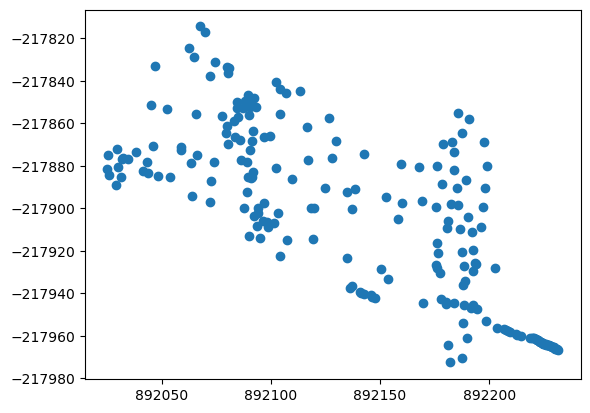

In [107]:
plt.scatter(cameraeasting, cameranorthing)

In [108]:
cameradata

SourceFile     DateTimeOriginal  SubSecTimeOriginal  \
0    images/P0550757.JPG  2021:03:15 13:25:29                 838   
1    images/P0550758.JPG  2021:03:15 13:25:31                 706   
2    images/P0550759.JPG  2021:03:15 13:25:33                 489   
3    images/P0550760.JPG  2021:03:15 13:25:35                 323   
4    images/P0550761.JPG  2021:03:15 13:25:38                 487   
..                   ...                  ...                 ...   
208  images/P0570965.JPG  2021:03:15 13:41:57                 729   
209  images/P0570966.JPG  2021:03:15 13:42:01                 211   
210  images/P0570967.JPG  2021:03:15 13:42:04                 812   
211  images/P0570968.JPG  2021:03:15 13:42:08                 107   
212  images/P0570969.JPG  2021:03:15 13:42:11                 415   

     GPSLatitude  GPSLongitude  GPSAltitude  AboveGroundAltitude  \
0      81.536151     31.271890     2.090399             7.331089   
1      81.536155     31.271890     2.137449             7.332376   
2      81.536160     31.271893     2.267962             7.322523   
3      81.536164     31.271898     2.469268             7.347524   
4      81.536168     31.271910     2.425748             7.359692   
..           ...           ...          ...                  ...   
208    81.538128     31.274360    17.538359            25.148806   
209    81.538137     31.274122    12.536938            19.790482   
210    81.538103     31.274419    10.279747            15.866547   
211    81.538077     31.274659     6.321928            13.094042   
212    81.538125     31.274399     1.528043             7.806284   

     GPSXYAccuracy  GPSZAccuracy  CameraPitchDegree  CameraRollDegree  \
0         0.714213           1.7          60.000492         -0.019994   
1         0.735527           1.7          20.000002         -0.010636   
2         0.742496           1.7         -20.000015         -0.010634   
3         0.756637           1.8         -60.000439         -0.020004   
4         0.728354           1.7         -60.000454         -0.019999   
..             ...           ...                ...               ...   
208       0.757430           1.9         -80.999222         23.949286   
209       0.772334           2.0         -80.337204         30.636055   
210       0.800562           2.0         -76.003944         54.424095   
211       0.843860           2.0         -79.040817        -41.903111   
212       0.878635           2.1         -81.004784        -23.710806   

     CameraYawDegree  
0           7.159714  
1           7.590090  
2           7.599876  
3           7.613551  
4          47.141262  
..               ...  
208       -11.640842  
209       -31.965664  
210       -82.464722  
211        12.515827  
212        -5.266152  

[213 rows x 12 columns]

In [109]:
cam_utm = thetransform.transform(cameradata["GPSLatitude"], cameradata["GPSLongitude"])

In [110]:
cam_rawtimes = cameradata["DateTimeOriginal"].values
cam_rawtimes = cam_rawtimes
cam_rawtimes[0].split(' ')
cam_rawdays = [thistime.split(' ')[0] for thistime in cam_rawtimes]
cam_times = [thistime.split(' ')[1] for thistime in cam_rawtimes]
cam_days = [datetime.strptime(thisday, "%Y:%m:%d") for thisday in cam_rawdays]
cam_times = np.array(cam_times)

In [111]:
subseconds = [x / 10**len(str(x)) for x in cameradata["SubSecTimeOriginal"]]
subseconds[0:5]

[0.838, 0.706, 0.489, 0.323, 0.487]

In [112]:
cam_dayseconds=[]
i = 0
for thetime in cam_times:
    hour, minute, second = thetime.split(':')
    #print(len(thetime))
    #print(thetime)
    cam_dayseconds.append((int(int(hour)-3)*3600.0) + (int(minute) * 60.0) + float(subseconds[i]))
    i += 1

In [113]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, cam_dayseconds)

In [114]:
gnssdayseconds = np.array(gnssdayseconds)

In [115]:
len(cam_dayseconds)

213

In [116]:
trimmedeast = np.squeeze(gnssutm_d2[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm_d2[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [117]:
min(cam_dayseconds)

37500.134

In [118]:
max(cam_dayseconds)

38520.812

In [119]:
min(gnssdayseconds)

34991.0

In [120]:
max(gnssdayseconds)

46714.0

In [121]:
timesteps = np.arange(trimmedtime.min()-0.5, trimmedtime.max()+0.5, 0.001)
timesteps = np.round(timesteps, 3)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)

In [122]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in cam_dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])
    else:
        print(thistimeindex[0])

CPU times: user 48 ms, sys: 182 µs, total: 48.2 ms
Wall time: 46.9 ms


In [123]:
gnss_cam_match_eastings = np.squeeze(interp_east[timeindexes])
gnss_cam_match_northings = np.squeeze(interp_north[timeindexes])

In [124]:
local_cam_east = cameraeasting - gnss_cam_match_eastings
local_cam_north = cameranorthing - gnss_cam_match_northings

In [125]:
local_cam_east[0]

46.70240628288593

In [126]:
plt.scatter(local_cam_east, local_cam_north)

ValueError: x and y must be the same size

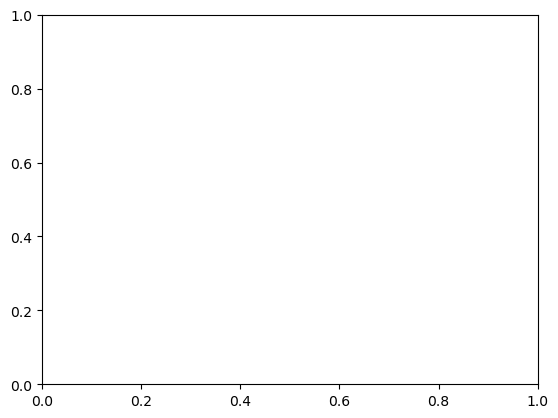

In [127]:
plt.scatter(gnssutm_d2[0], gnssutm[1])
#plt.scatter(gnss_cam_match_eastings, gnss_cam_match_northings)
plt.scatter(gnss_gem2_match_eastings,gnss_gem2_match_northings, label = "gem2")
plt.scatter(gnss_mp_match_eastings, gnss_mp_match_northings, label = "MP")

plt.legend()


In [ ]:
world_cam_east = local_cam_east + gnssutm[0][0]
world_cam_north = local_cam_north + gnssutm[1][0]

In [128]:
world_cam_east[0]

891171.4160559671

In [129]:
world_gem2_east[0]

NameError: name 'world_gem2_east' is not defined

NameError: name 'gnss_mp_match_eastings' is not defined

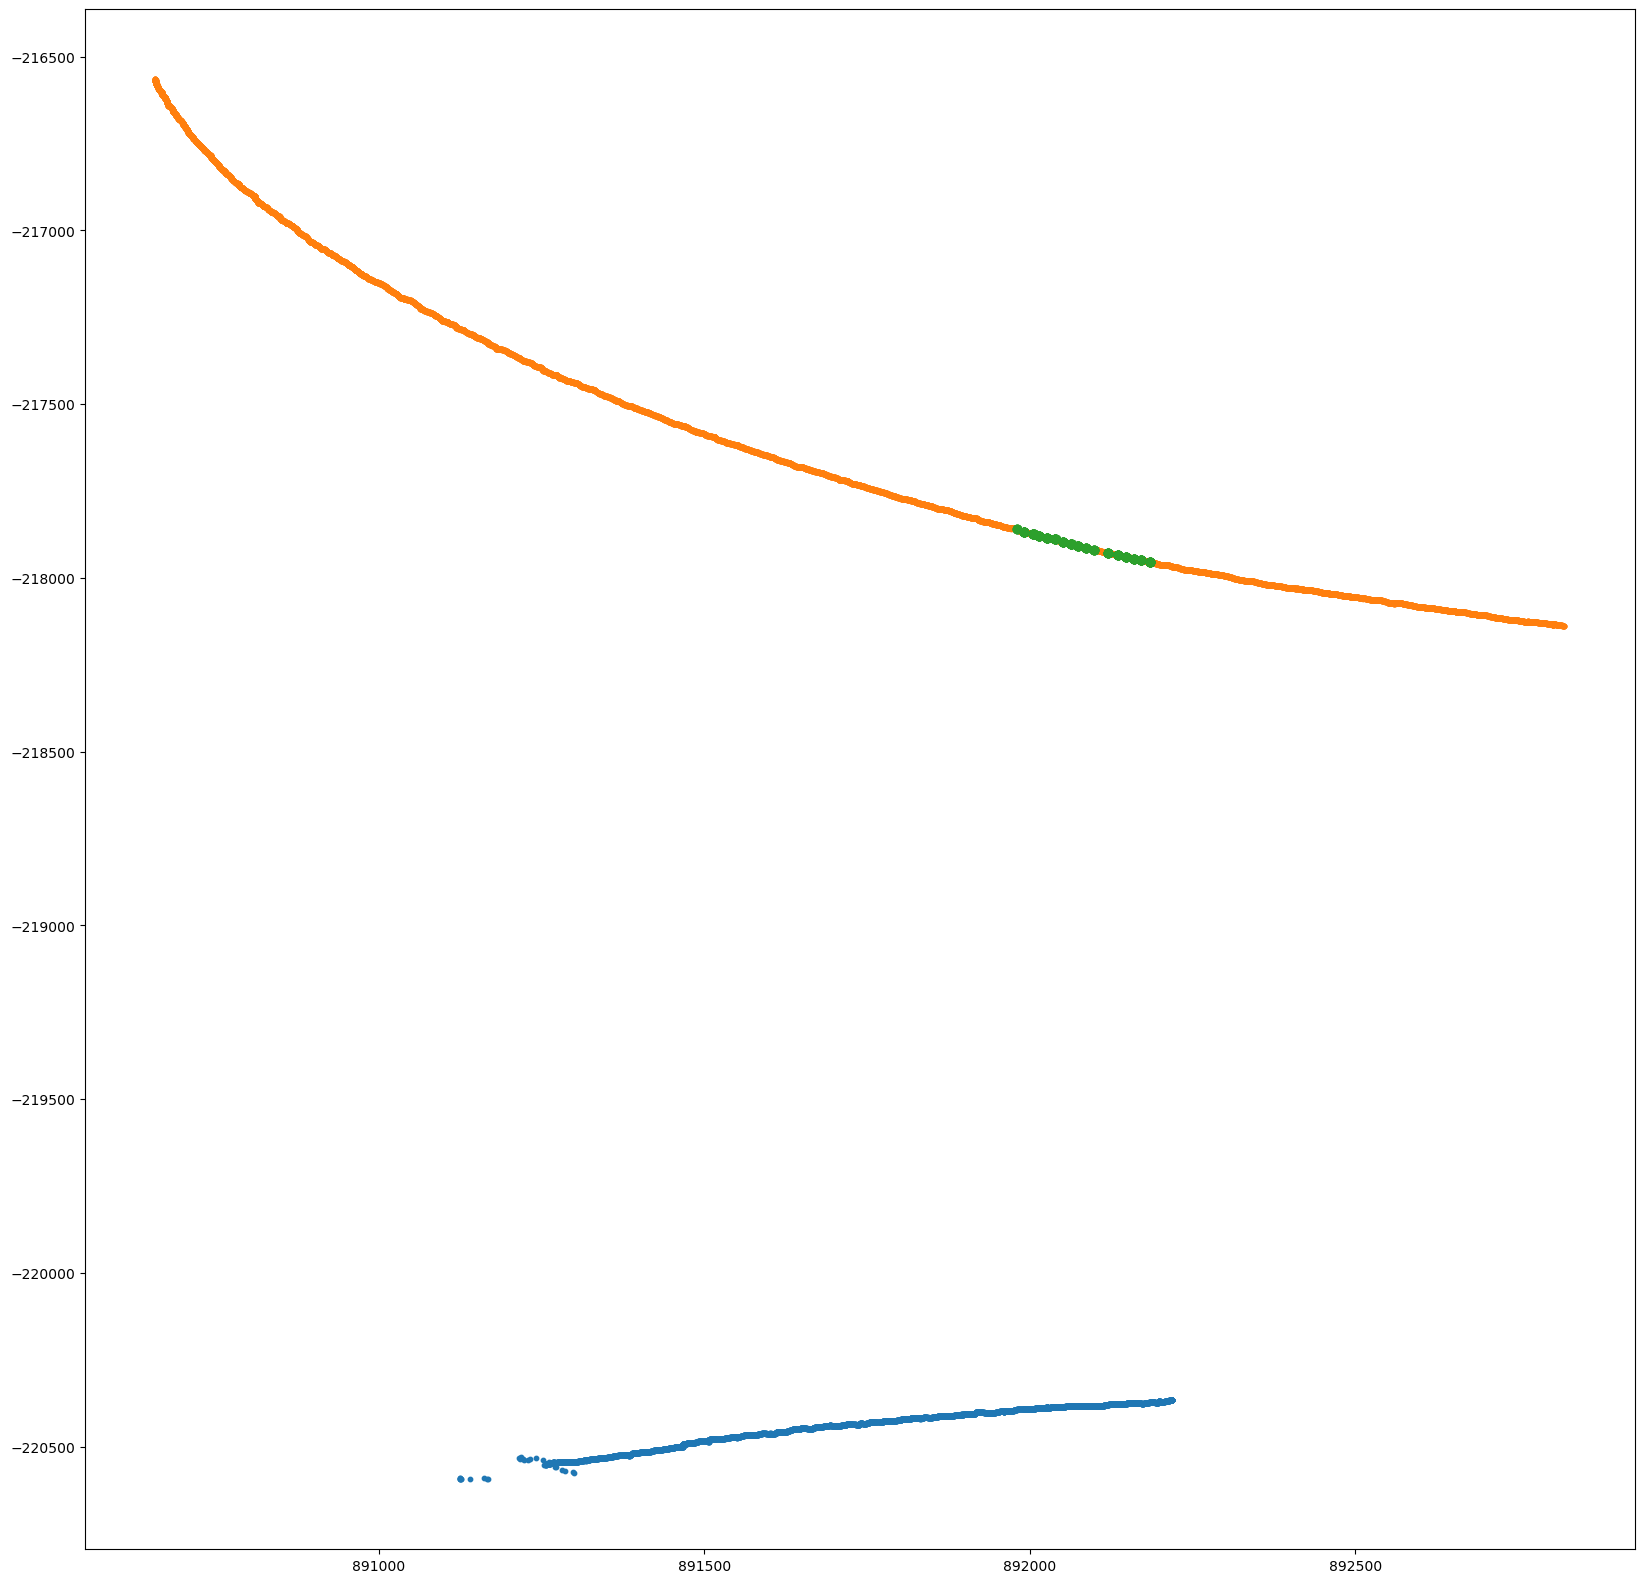

In [130]:
fig = plt.figure(figsize=(20,20))

plt.scatter(gnssutm[0],gnssutm[1], s = 10, label = 'day 1 drift track')
plt.scatter(gnssutm_d2[0],gnssutm_d2[1], s = 10, label = 'day 2 drift track')
plt.scatter(gnss_cam_match_eastings, gnss_cam_match_northings)
plt.scatter(gnss_mp_match_eastings, gnss_mp_match_northings)
plt.scatter(gnss_gem2_match_eastings, gnss_gem2_match_northings)

plt.scatter(world_gem2_east, world_gem2_north, c=f1530hz_hcp_i, cmap = "Blues", s=200, label = "GEM2")
plt.scatter(world_mp_east, world_mp_north, c = mpdata["DepthCm"]/100, label = "Magnaprobe")
plt.scatter(world_cam_east, world_cam_north, c = cameradata["AboveGroundAltitude"], label = "camera centres", cmap="Greens")
plt.legend()
plt.grid()
ax = plt.gca()
ax.set_aspect("equal")
plt.savefig("/mnt/documents/Q1/P6-14032021/driftracks.png")

In [131]:
backtolatlon = pyproj.transformer.Transformer.from_proj(3413,4326)

In [132]:
cam_latlon = backtolatlon.transform(world_cam_east, world_cam_north)

In [133]:
cam_out = cameradata.copy()

In [134]:
cam_out["GPSLatitude"] = cam_latlon[0]

In [135]:
cam_out["GPSLongitude"] = cam_latlon[1]

In [136]:
mp_output_exiftool = "/mnt/documents/ANAFI_USA_data/AeN_Q1_2021_P6_15032021/driftcorrected-for-exiftool.csv"

In [137]:
cam_out.to_csv(mp_output_exiftool, index=False)

In [138]:
cam_out['GPSLatitude'][0] - cameradata["GPSLatitude"][0]

0.003672542563293746

In [139]:
cam_out['GPSLatitude'][0]

81.53982354253549

cam_o

In [140]:
cam_out_hag = cam_out.copy()

In [141]:
cam_out_hag["GPSAltitude"] = cam_out_hag["AboveGroundAltitude"]

In [142]:
cam_out_hag.drop(columns = ["AboveGroundAltitude"], inplace = True)

In [143]:
cam_output_exiftool_hag = "/mnt/documents/ANAFI_USA_data/AeN_Q1_2021_P6_15032021/driftcorrected-for-exiftool-HAG.csv"

In [144]:
cam_out_hag.to_csv(cam_output_exiftool_hag, index=False)